In [2]:
# INITIALIZING LIBRARIES:
import math
import torch
from torch import nn 
from d2l import torch as d2l

In [3]:
# DEFINING MASKED SOFTMAX FUNCTION:
def masked_softmax(X, valid_lens):
    """Perform softmax operation"""
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


# INSPECTION:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5297, 0.4703, 0.0000, 0.0000],
         [0.4917, 0.5083, 0.0000, 0.0000]],

        [[0.3553, 0.3008, 0.3440, 0.0000],
         [0.3865, 0.1867, 0.4268, 0.0000]]])

In [4]:
# INSPECTION:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3063, 0.4334, 0.2603, 0.0000]],

        [[0.5051, 0.4949, 0.0000, 0.0000],
         [0.1961, 0.1883, 0.2713, 0.3443]]])

**Batch Matrix Multiplication**

In [7]:
# EXAMPLE OF BATCH MULTIPLICATION:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

**Scaled Dot-Product Attention**

In [8]:
# IMPLEMENTATION OF SCALED DOT-PRODUCT ATTENTION:
class DotProductAttention(nn.Module):
    """Scaled dot product attention"""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads 
    
    # Shape of queries: (batch_size, no_of_queries, d)
    # Shape of keys: (batch_size, no_of_keyvalue_pairs, d)
    # Shape of values: (batch_size, no_of_keyvalue_pairs, value_dimension)
    # Shape of valid_lens: (batch_size) or (batch_size, no_of_queries)
    # Shape of window_mask: (num_windows, no_of_queries, no_of_keyvalue_pairs)

    def forward(self, queries, keys, values, valid_lens=None, window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if window_mask is not None:
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            scores = scores.reshape((n//(num_windows * self.num_heads), num_windows, 
                                     self.num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [9]:
# IMPLEMENTATION OF SCALED DOT PRODUCT ATTENTION:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

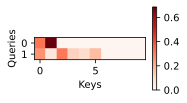

In [10]:
# INSPECTING THE HEATMAP:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel="Keys",
                  ylabel="Queries")

**Additive Attention**

In [11]:
# IMPLEMENTATION OF ADDITIVE ATTENTION:
class AdditiveAttention(nn.Module):
    """Additive attention"""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.W_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [12]:
# IMPLEMENTATION OF ADDITIVE ATTENTION:
queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

c:\Users\ROG\anaconda3\envs\thinam_d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


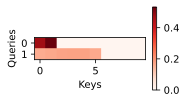

In [13]:
# INSPECTING THE HEATMAP:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel="Keys",
                  ylabel="Queries")